In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4, "

from pathlib import Path
from omegaconf import OmegaConf
import numpy as np
from PIL import Image, ImageChops, ImageOps, ImageFilter
import imageio
import torch
from torchvision.utils import make_grid
import torch.nn.functional as F
from einops import rearrange
import diffusers
import transformers

from models.unet_2d_condition import UNet2DConditionModel
from models.unet_3d import UNet3DConditionModel
from models.mutual_self_attention import ReferenceAttentionControl
from models.guidance_encoder import GuidanceEncoder
from pipelines.pipeline_aggregation import MultiGuidance2LongVideoPipeline

# diffusers==0.24.0

In [2]:
cfg = OmegaConf.load("./configs/inference.yaml")

vae = diffusers.AutoencoderKL.from_pretrained(cfg.vae_model_path)
image_enc = transformers.CLIPVisionModelWithProjection.from_pretrained(cfg.image_encoder_path)

denoising_unet = UNet3DConditionModel.from_pretrained_2d(
    cfg.base_model_path,
    cfg.motion_module_path,
    subfolder="unet",
    unet_additional_kwargs=cfg.unet_additional_kwargs,
)
denoising_unet.load_state_dict(
    torch.load(Path(cfg.ckpt_dir) / "denoising_unet.pth", map_location="cpu"), 
    strict=False
)
denoising_unet.enable_xformers_memory_efficient_attention()

reference_unet = UNet2DConditionModel.from_pretrained(
    cfg.base_model_path,
    subfolder="unet",
)
reference_unet.load_state_dict(
    torch.load(Path(cfg.ckpt_dir) / "reference_unet.pth", map_location="cpu"), 
    strict=False
)
reference_unet.enable_xformers_memory_efficient_attention()

guidance_encoder_group = {}
for guidance_type in ["depth", "normal", "semantic_map", "dwpose"]:
    guidance_encoder_module = GuidanceEncoder(
        guidance_embedding_channels=cfg.guidance_encoder_kwargs.guidance_embedding_channels,
        guidance_input_channels=cfg.guidance_encoder_kwargs.guidance_input_channels,
        block_out_channels=cfg.guidance_encoder_kwargs.block_out_channels,
    )
    guidance_encoder_module.load_state_dict(
        torch.load(Path(cfg.ckpt_dir) / f"guidance_encoder_{guidance_type}.pth", map_location="cpu"),
        strict=False,
    )
    guidance_encoder_group[f"guidance_encoder_{guidance_type}"] = guidance_encoder_module
    

sched_kwargs = OmegaConf.to_container(cfg.noise_scheduler_kwargs)
if cfg.enable_zero_snr:
    sched_kwargs.update( 
        rescale_betas_zero_snr=True,
        timestep_spacing="trailing",
        prediction_type="v_prediction",
    )
scheduler = diffusers.DDIMScheduler(**sched_kwargs)

pipeline = MultiGuidance2LongVideoPipeline(
    vae=vae,
    image_encoder=image_enc,
    reference_unet=reference_unet,
    denoising_unet=denoising_unet,
    **guidance_encoder_group,
    scheduler=scheduler
).to("cuda:0", dtype=torch.float16)

generator = torch.Generator("cuda:0")

Some weights of the model checkpoint were not used when initializing UNet2DConditionModel: 
 ['conv_norm_out.weight, conv_norm_out.bias, conv_out.weight, conv_out.bias']


In [33]:
ref_image_path = Path("/data/3D_dataset/GrabNet/images/temp/test1-320.png")
motion_guidance_path = Path("/data/3D_dataset/GrabNet/images/temp/s3-flute_play_1-640")
seed = 1234
vid_len = 16

ref_image = Image.open(ref_image_path).convert("RGB")
ref_image_w, ref_image_h = ref_image.size
target_w = 512
target_h = int((ref_image_h / ref_image_w * target_w) // 8 * 8)

guide_dict = {"depth" : "sao_depth", "normal" : "sao_normal", "semantic_map" : "sbj_semantic_map", "dwpose" : "sbj_dwpose", "mask" : "sao_mask"}
guidance_pil_group = dict()
for guidance_type in ['depth', 'normal', 'semantic_map', 'dwpose']:
    guidance_pil_group[guidance_type] = []
    guidance_image_path = motion_guidance_path / f"{guide_dict[guidance_type]}.png"
    guidance_img = Image.open(guidance_image_path).convert("RGB")
    if guidance_type == "semantic_map":
        mask_path = motion_guidance_path / f"{guide_dict['mask']}.png"
        mask_array = np.array(Image.open(mask_path).convert("RGB"))
        guidance_img = Image.fromarray(np.where(mask_array > 0, np.array(guidance_img), 0))
    guidance_img = guidance_img.resize((target_w, target_h))
    guidance_pil_group[guidance_type] += [guidance_img] * vid_len

video_length = len(list(guidance_pil_group.values())[0])

In [34]:
with torch.inference_mode():
    video_tensor = pipeline(
        ref_image,
        {k:v for k,v in guidance_pil_group.items() if k in ['depth', 'normal', 'semantic_map', 'dwpose']},
        target_w, target_h,
        video_length,
        num_inference_steps=cfg.num_inference_steps,
        guidance_scale=cfg.guidance_scale,
        generator=generator.manual_seed(seed)
    ).videos

B, C, video_length, H, W = video_tensor.shape
video_tensor_reshaped = video_tensor.reshape(-1, C, H, W)
resized_frames = F.interpolate(video_tensor_reshaped, size=(ref_image_h, ref_image_w), mode='bilinear', align_corners=False)
resized_video = resized_frames.reshape(B, C, video_length, ref_image_h, ref_image_w).permute(2,0,1,3,4)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 21.71it/s]


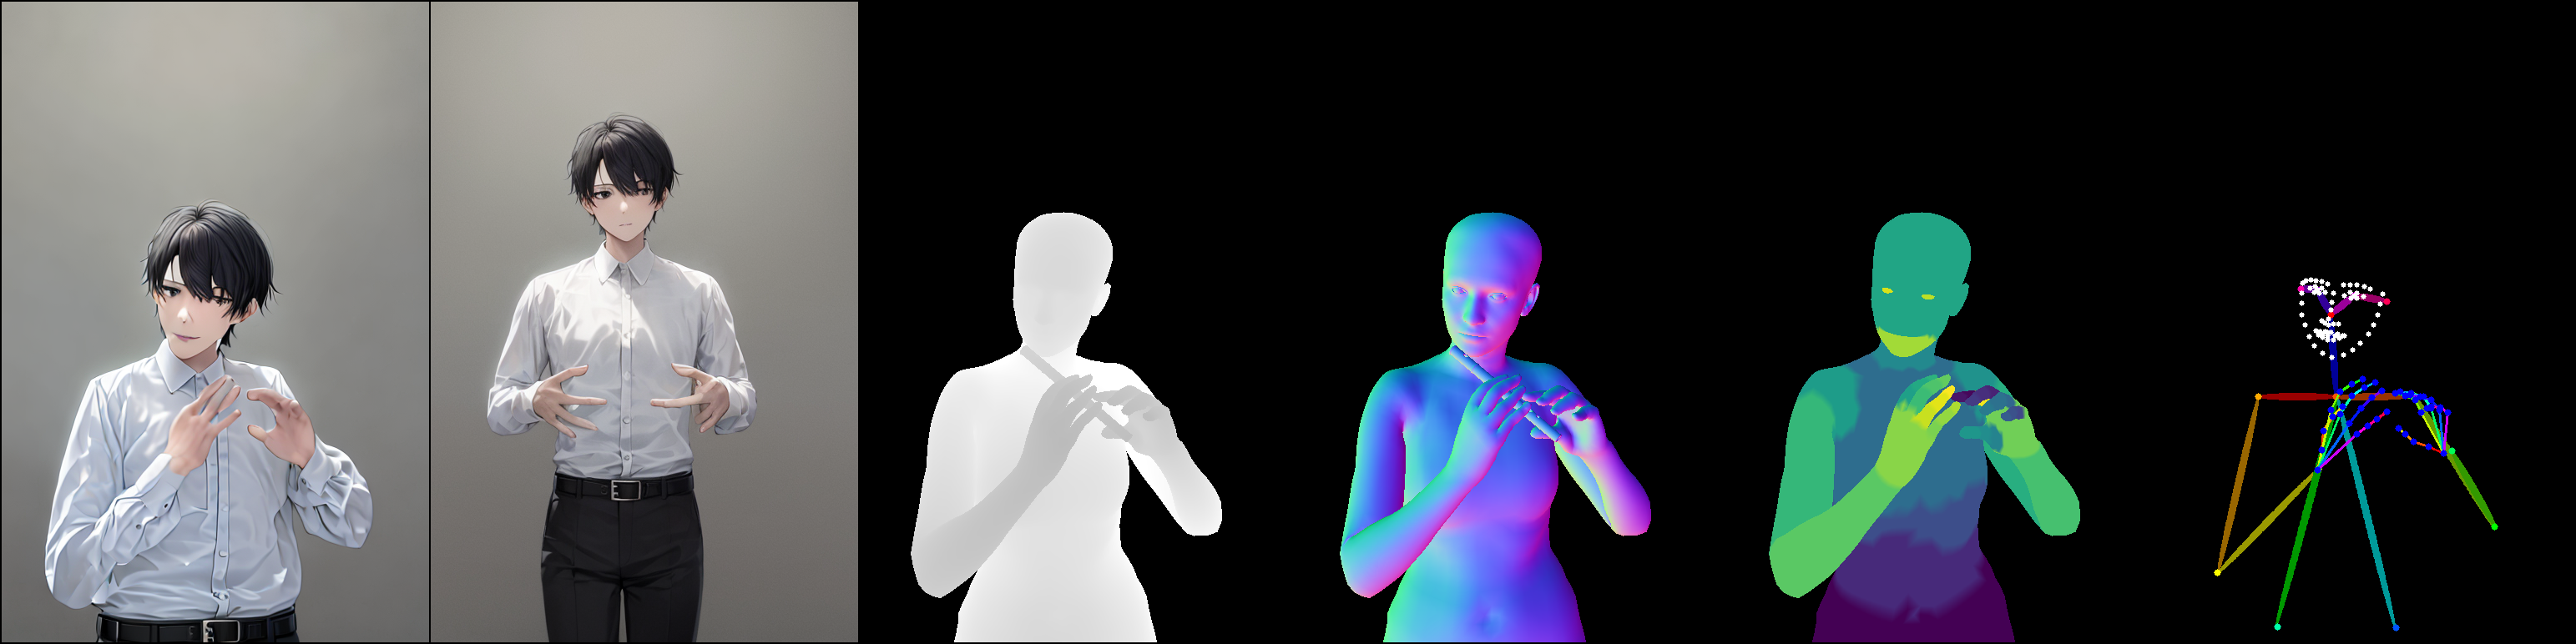

In [35]:
ref_image_tensor = pipeline.ref_image_processor.preprocess(ref_image, height=target_h, width=target_w)
row = [resized_video[0], (ref_image_tensor+1)/2.]
for k in list(guidance_pil_group.keys()):
    im2 = guidance_pil_group[k][0]
    im2 = torch.from_numpy(np.array(im2)) / 255.0
    im2 = im2.permute(2,0,1).unsqueeze(0).cpu()
    row.append(im2)
im2 = torch.cat(row)
x = make_grid(im2, nrow=6).permute(1,2,0)
Image.fromarray((x * 255.).numpy().astype(np.uint8))

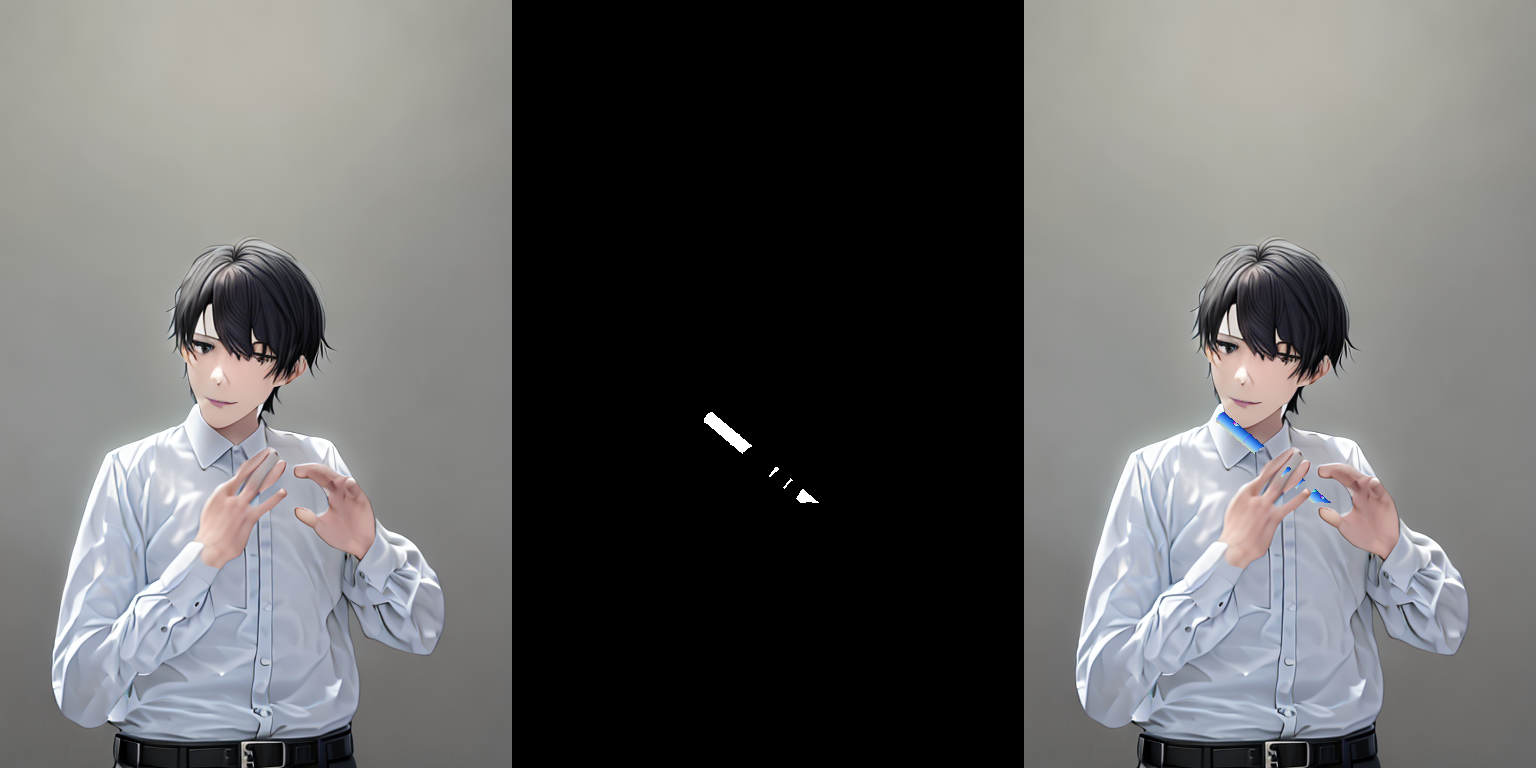

In [36]:
obj_depth = Image.open(motion_guidance_path / "obj_normal.png").convert("RGB")
obj_mask = Image.open(motion_guidance_path / "obj_mask.png").convert("1")
hand_mask = Image.open(motion_guidance_path / "hand_mask.png").convert("1")
hand_mask = hand_mask.filter(ImageFilter.MaxFilter(1))

result_img = pipeline.ref_image_processor.postprocess(resized_video[0], do_denormalize=[False])[0]
result_mask = ImageChops.logical_and(obj_mask, ImageOps.invert(hand_mask))
comp_img = Image.composite(result_img, obj_depth, ImageOps.invert(result_mask))

result = Image.new('RGB', (target_w * 3, target_h))
result.paste(result_img, (0,0))
result.paste(result_mask, (target_w*1, 0))
result.paste(comp_img, (target_w*2, 0))
result

In [61]:
ref_image_path = Path("example_data/ref_images/test_output2.png")
motion_guidance_path = Path("/shared/3D-gen/priorMDM/behave-dataset/out/Date01_Sub01_monitor_hand")
seed = 1234
# vid_len = 208

ref_image = Image.open(ref_image_path).convert("RGB")
ref_image_w, ref_image_h = ref_image.size
target_w = 512
target_h = int((ref_image_h / ref_image_w * target_w) // 8 * 8)

guidance_pil_group = dict()
for guidance_type in ['depth', 'normal', 'semantic_map', 'dwpose', 'frames', 'mask']:
    guidance_pil_group[guidance_type] = []
    guidance_images = sorted(list(motion_guidance_path.glob(f"{guidance_type}/*.png")))
    for guidance_image_path in guidance_images:
        guidance_img = Image.open(guidance_image_path).convert("RGB").resize((1024, 768))
        if guidance_type == "semantic_map":
            mask_path = Path(motion_guidance_path) / "mask" / guidance_image_path.name
            mask_array = np.array(Image.open(mask_path).convert("RGB").resize((1024, 768)))
            guidance_img = Image.fromarray(np.where(mask_array > 0, np.array(guidance_img), 0))
        guidance_img = guidance_img.crop((
            (guidance_img.size[0] - target_w) // 2, 
            (guidance_img.size[1] - target_h) // 2, 
            (guidance_img.size[0] - target_w) // 2 + target_w, 
            (guidance_img.size[1] - target_h) // 2 + target_h, 
        ))
        guidance_pil_group[guidance_type] += [guidance_img]

video_length = len(list(guidance_pil_group.values())[0])

In [64]:
with torch.inference_mode():
    video_tensor = pipeline(
        ref_image,
        {k:v for k,v in guidance_pil_group.items() if k in ['depth', 'normal', 'semantic_map', 'dwpose']},
        target_w, target_h,
        video_length,
        num_inference_steps=cfg.num_inference_steps,
        guidance_scale=cfg.guidance_scale,
        generator=generator.manual_seed(seed)
    ).videos

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:02<00:00, 21.14it/s]


In [70]:
output_path = Path("test3.mp4")

B, C, video_length, H, W = video_tensor.shape
video_tensor_reshaped = video_tensor.reshape(-1, C, H, W)
resized_frames = F.interpolate(video_tensor_reshaped, size=(ref_image_h, ref_image_w), mode='bilinear', align_corners=False)
resized_video = resized_frames.reshape(B, C, video_length, ref_image_h, ref_image_w).permute(2,0,1,3,4)

writer = imageio.get_writer(output_path, fps=6)
for i, x in enumerate(resized_video):
    row = [x]
    for k in list(guidance_pil_group.keys()):
        im2 = guidance_pil_group[k][i]
        im2 = torch.from_numpy(np.array(im2)) / 255.0
        im2 = im2.permute(2,0,1).unsqueeze(0).to(x.device)
        row.append(im2)
    im2 = torch.cat(row)
    x = make_grid(im2, nrow=7).permute(1,2,0)
    x = (x * 255.).numpy().astype(np.uint8)
    writer.append_data(x)
writer.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (3600, 692) to (3600, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
